In [3]:
import chess
from chess import svg
from IPython.display import SVG
from IPython.display import clear_output


In [4]:
class Checkers:
    def __init__(self):
        self.size = 8
        self.turn = chess.BLACK
        self.board = chess.Board("1p1p1p1p/p1p1p1p1/1p1p1p1p/8/8/P1P1P1P1/1P1P1P1P/P1P1P1P1 b KQkq - 0 4")
    
    def isCellEmpty(self, i):
        return self.board.piece_at(i) is None
    
    def changeTurn(self, turn):
        if turn is chess.WHITE:
            return chess.BLACK
        else:
            return chess.WHITE
    
    def displayBoard(self):
        display(svg.board(board = self.board))
            
    def ifIsPositionWithinBoundary(self, x, y):
        return x>=0 and y>=0 and x<self.size and y<self.size
    
    def bottomRight(self, pos):
        x, y = pos//self.size-1, pos%self.size+1
        return x*self.size+y if self.ifIsPositionWithinBoundary(x,y) else None 
    
    def bottomLeft(self, pos):
        x, y = pos//self.size-1, pos%self.size-1
        return x*self.size+y if self.ifIsPositionWithinBoundary(x,y) else None 
    
    def topRight(self, pos):
        x, y = pos//self.size+1, pos%self.size+1
        return x*self.size+y if self.ifIsPositionWithinBoundary(x,y) else None 
        
    def topLeft(self, pos):
        x, y = pos//self.size+1, pos%self.size-1
        return x*self.size+y if self.ifIsPositionWithinBoundary(x,y) else None
    
    def pieceAtPosition(self,pos):
        return self.board.piece_at(pos)
        
    def validNeighbors(self,pos):
        tl = self.topLeft(pos)
        tr = self.topRight(pos)
        bl = self.bottomLeft(pos)
        br = self.bottomRight(pos)
        valid = []
        piece = self.pieceAtPosition(pos)
        if piece is None:
            raise Exception("Sorry, no piece present at position" + str(pos))
        
        if piece.piece_type == chess.PAWN and piece.color == chess.WHITE:
            if tl is not None:
                valid.append(tl)
            if tr is not None:
                valid.append(tr)
                
        elif piece.piece_type == chess.PAWN and piece.color == chess.BLACK:
            if bl is not None:
                valid.append(bl)
            if br is not None:
                valid.append(br)
                
        else:
            if tl is not None:
                valid.append(tl)
            if tr is not None:
                valid.append(tr)
            if bl is not None:
                valid.append(bl)
            if br is not None:
                valid.append(br)
                
        return valid
    
        
    def getOppColorPieces(self, neighbors, color):
        return [neighbor for neighbor in neighbors if self.pieceAtPosition(neighbor) is not None \
                               and self.pieceAtPosition(neighbor).color is not color]
    
    def validJumps(self, pos1, pos2):
        x1, y1 = pos1//self.size, pos1%self.size
        x2, y2 = pos2//self.size, pos2%self.size
        x, y = 2 *  x2 - x1, 2 * y2 - y1
        return x*self.size+y if self.ifIsPositionWithinBoundary(x,y) and self.isCellEmpty(x*self.size+y) else None
    
    def getFirstJumpsForPos(self, pos):
        jumps = []
#         print(pos)
        oppColorPositons = self.getOppColorPieces(self.validNeighbors(pos), self.board.piece_at(pos).color)
        for positions in oppColorPositons:
            if self.validJumps(pos,positions) is not None:
                jumps.append(self.validJumps(pos,positions))
        return jumps
            
    def getAllFirstJumps(self, turn):
        firstJumps = {}
        allPiecesPosition = [position for position in self.board.piece_map().keys() if self.board.piece_at(position).color == turn]
        for position in allPiecesPosition:
            firstJumpPos = self.getFirstJumpsForPos(position)
            if len(firstJumpPos) is not 0:
                firstJumps[position] = firstJumpPos
        return firstJumps
    

    def getCaptureMovesForPos(self, pos):
        paths = []
        
        testing = self.getFirstJumpsForPos(pos)

        for nextPos in testing:

          pieceRemoved, isConvertedToKing = self.makeMoveForRecursion(pos, nextPos)
          remainingPaths = self.getCaptureMovesForPos(nextPos)

          if not remainingPaths:
            paths.append([nextPos])

          else:
            for remainingPath in remainingPaths:
              paths.append([nextPos] + remainingPath)

          self.unMove(pos, nextPos, pieceRemoved, isConvertedToKing)
        
        return paths
    
    def makeMoveForRecursion(self, i, j):
        piece = self.board.remove_piece_at(i)
        self.board.set_piece_at(j, piece)
        isConverted = self.convertToKing(j)
        if self.isCaptureMove(i, j):
          return self.capturePiece(i, j), isConverted
        
        else:
          return None, isConverted


    def getAllCaptureMoves(self, turn):
      moves = {}
      allPiecesPosition = [position for position in self.board.piece_map().keys() if self.board.piece_at(position).color == turn]
      for position in allPiecesPosition:
          captureMoves = self.getCaptureMovesForPos(position)
          if captureMoves:
              moves[position] = captureMoves
      return moves
        


            
    def capturePiece(self, fromPos, toPos):
      x1, y1 = fromPos//self.size, fromPos%self.size
      x2, y2 = toPos//self.size, toPos%self.size

      # add checks for valid jump
      # add checks for piece in between

      x, y = (x1 + x2) // 2, (y1 + y2) // 2

      return self.board.remove_piece_at(x * self.size + y)  
                
    def unCapturePiece(self, fromPos, toPos, piece):
      x1, y1 = fromPos//self.size, fromPos%self.size
      x2, y2 = toPos//self.size, toPos%self.size

      # add checks for valid jump
      # add checks for piece in between

      x, y = (x1 + x2) // 2, (y1 + y2) // 2

      self.board.set_piece_at(x * self.size + y, piece)  


    
    def getRemainingMovesForPos(self, pos):
        return [positions for positions in self.validNeighbors(pos) if self.isCellEmpty(positions)]
    
    
    def getAllRemainingMoves(self, turn):
        moves = {}
        allPiecesPosition = [position for position in self.board.piece_map().keys() if self.board.piece_at(position).color == turn]
        for position in allPiecesPosition:
            moveForPos = self.getRemainingMovesForPos(position)
            if len(moveForPos) is not 0:
                moves[position] = moveForPos
        return moves
    
    def isValidMove(self, i, j):
        if self.isCellEmpty(i) or self.board.piece_at(i).color is not self.turn:
            return False
        
        moves = self.getAllFirstJumps(self.turn)
        
        if not moves:
            moves = self.getAllRemainingMoves(self.turn)
            
        return i in moves and j in moves[i]
            
    def isCaptureMove(self, i, j):
      return abs((j % self.size) - (i % self.size)) == 2
    
    def convertToKing(self, i):
        if self.board.piece_at(i).piece_type == chess.KING:
            return False
        
        if self.board.piece_at(i).color is chess.WHITE and i in range(56,64):
            self.board.set_piece_at(i, chess.Piece(chess.KING, chess.WHITE))
            return True
        if self.board.piece_at(i).color is chess.BLACK and i in range(0,8):
            self.board.set_piece_at(i, chess.Piece(chess.KING, chess.BLACK))
            return True
        
        return False
        
            
    
    def makeMove(self, i, j):
        if self.isValidMove(i, j):
            piece = self.board.remove_piece_at(i)
            self.board.set_piece_at(j, piece)
            isConverted = self.convertToKing(j)
        else:
            return None, None
            
        if self.isCaptureMove(i, j):
          return self.capturePiece(i, j), isConverted
        
        else:
          return None, isConverted
    
    def isGameComplete(self):
        if not self.getAllCaptureMoves(chess.WHITE) and not self.getAllRemainingMoves(chess.WHITE):
            return 1 
        elif not self.getAllCaptureMoves(chess.BLACK) and not self.getAllRemainingMoves(chess.BLACK):
            return 0 
        return -1
    
    def getAllMoves(self, turn):
        if self.getAllCaptureMoves(turn):
            return self.getAllCaptureMoves(turn)
        else:
            return self.getAllRemainingMoves(turn)
    
    def unMove(self, i, j, pieceToPlace, isConvertedToKing):
      piece = self.board.remove_piece_at(j)
      if isConvertedToKing:
        piece.piece_type = chess.PAWN
        
      self.board.set_piece_at(i, piece)

      if pieceToPlace is not None:
        self.unCapturePiece(i, j, pieceToPlace)  
        
    def minMax(self,depth,isMaxPlayer, alpha, beta):
        if depth>5:
            return {'position' : None, 'prize' : 0}
        
        if isMaxPlayer:
            turn = chess.WHITE
        else:
            turn = chess.BLACK
            
        finalState = self.isGameComplete()
        if finalState in [0,1]:
            if finalState == 0:
                return {'position' : None, 'prize' : 100-depth}
            else:
                return {'position' : None, 'prize' : -100+depth}
    
        if isMaxPlayer:
            best = -50
        else:
            best = 50
    
        moves = self.getAllMoves(turn)
      
        for move in moves.keys():
            for options in moves[move]:
                if isinstance(options,list):
                    stack = []
                    i = move
                    for j in options:
                        piece, isKing = self.makeMoveForRecursion(i,j)
                        stack.append((piece, isKing))
                        i = j
                        
                    recur = self.minMax(depth+1,not isMaxPlayer, alpha, beta)
                    
                    j = options.pop()
                    options.insert(0,move)
                    for i in reversed(options):
                        piece, isKing = stack.pop()
                        self.unMove(i, j, piece, isKing)
                        j = i
                    
                    if isMaxPlayer:
                        if recur['prize'] > best:
                            best = recur['prize']
                            nextMove = (move,options)
                            alpha = max(alpha,best)
                            if alpha>=beta:
                                break

                    else:
                        if recur['prize'] < best:
                            best = recur['prize']
                            nextMove = (move,options)
                            beta = min(beta,best)
                            if alpha>=beta:
                                break
                        
                else:
                    piece, isKing = self.makeMoveForRecursion(move,options)
                    recur = self.minMax(depth+1,not isMaxPlayer, alpha, beta)
                    self.unMove(move, options, piece, isKing)

                    if isMaxPlayer:
                        if recur['prize'] > best:
                            best = recur['prize']
                            nextMove = (move,[options])
                            alpha = max(alpha,best)
                            if alpha>=beta:
                                break

                    else:
                        if recur['prize'] < best:
                            best = recur['prize']
                            nextMove = (move,[options])
                            beta = min(beta,best)
                            if alpha>=beta:
                                break
        
        return {'position': nextMove, 'prize': best}
        
        
        
    
    def play(self,youFirst = True):
        print("\t Checkers \n Bot = Black \n You = White ")
        while True:
          res = self.isGameComplete()
          if res in [0,1]:
            if res == 0:
              print("WHITE Wins")
              self.displayBoard()
            elif res == 1:
              print("BLACK Wins")
              self.displayBoard()
            break
          if self.turn == chess.WHITE:
            print("White's Turn") 
          else:
            print("Black's Turn")
          self.displayBoard()
          
          if self.turn == chess.BLACK:
            i = int(input("Enter Start Location"))-1
            j = int(input("Enter End Location"))-1
          
            if not self.isValidMove(i,j):
              print("Invalid Input! Please enter another number ")
              continue
            
            piece, _ = self.makeMove(i,j)
          
            if piece is not None:
              leftMoves = self.getCaptureMovesForPos(j)
              if leftMoves:
                print("Continue to Capture")
                continue
            
          
          else:
            print("Bots Turn")
            d = self.minMax(0,True, -2000, 2000)
            i,move = d['position']
            print(move)
            for j in move:
              self.makeMoveForRecursion(i,j)
              i = j
        
          self.turn = self.changeTurn(self.turn)    
#           clear_output(True)
          

#     def minimax()
        

In [5]:
checkersLocal = Checkers()
checkersLocal.board = chess.Board("1p1p1p1p/p1p1p1p1/1p1p1p2/6p1/5P2/P1P1P3/1P1P1P1P/P1P1P1P1 b KQkq - 0 4")

checkersLocal.board
checkersLocal.isValidMove(16, 25)
# checkersLocal.getCaptureMovesForPos(16)


False

	 Checkers 
 Bot = Black 
 You = White 
Black's Turn


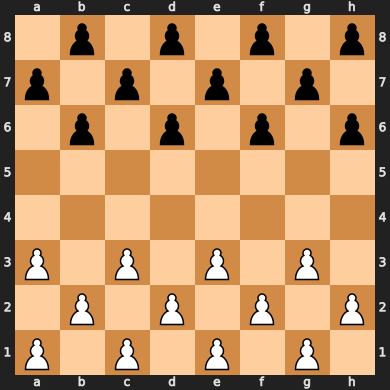

Enter Start Location49
Enter End Location68
Invalid Input! Please enter another number 
Black's Turn


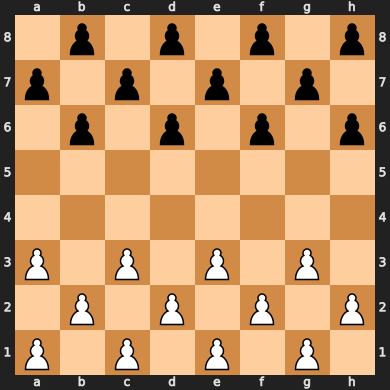

Enter Start Location48
Enter End Location39
White's Turn


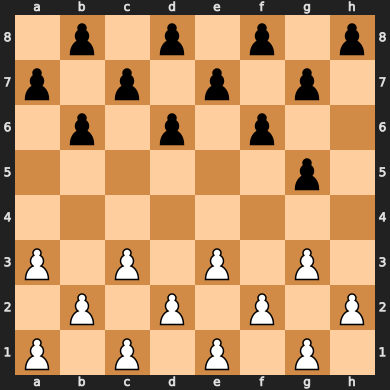

Bots Turn
[29]
Black's Turn


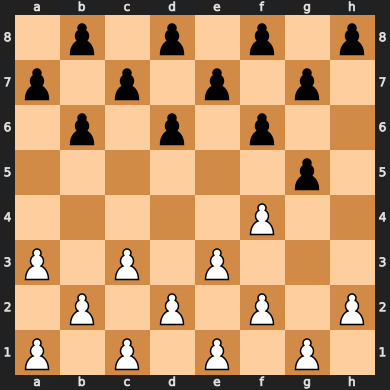

Enter Start Location46
Enter End Location37
White's Turn


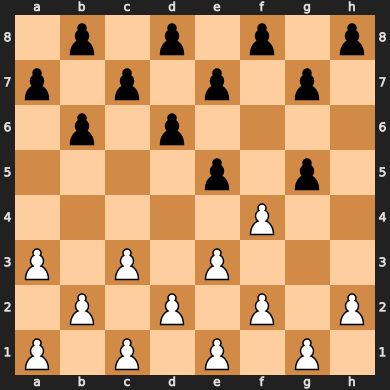

Bots Turn
[29]
Black's Turn


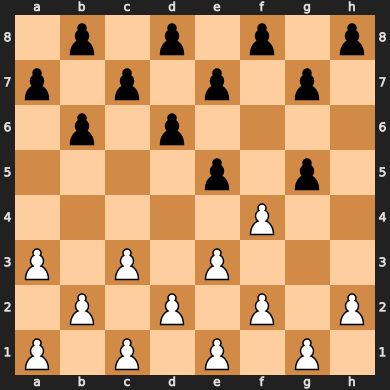

In [ ]:
checkers = Checkers()
checkers.play()

In [ ]:
import unittest
import chess
class UnitTest(unittest.TestCase):
    
    def setUp(self):
        self.checkers = Checkers()
        
    
    def test_initialize_board_correct(self):
        expected_board = chess.Board("1p1p1p1p/p1p1p1p1/1p1p1p1p/8/8/P1P1P1P1/1P1P1P1P/P1P1P1P1 b KQkq - 0 4")
        self.assertEqual(expected_board, self.checkers.board)
    
    def test_initialize_board_incorrect(self):
        expected_board = chess.Board("p1p1ppp1/1p1p1p1p/p1p1p1p1/8/8/1P1P1P1P/P1P1P1P1/1P1P1P1P b KQkq - 0 4")
        self.assertNotEqual(expected_board, self.checkers.board)
    
    def test_isEmpty(self):
        self.assertTrue(self.checkers.isCellEmpty(27))
        self.assertFalse(self.checkers.isCellEmpty(9))
    
    def test_isValidBottomRight(self):
        self.assertEqual(self.checkers.bottomRight(9),2)
        
    def test_isValidBottomLeft(self):
        self.assertEqual(self.checkers.bottomLeft(9),0)
        
    def test_isValidTopRight(self):
        self.assertEqual(self.checkers.topRight(9),18)
        
    def test_isValidTopLeft(self):
        self.assertEqual(self.checkers.topLeft(9),16)
    
    def test_isInvalidBottomRight(self):
        self.assertEqual(self.checkers.bottomRight(7),None)
        
    def test_isInvalidBottomLeft(self):
        self.assertEqual(self.checkers.bottomLeft(7),None)
        
    def test_isInvalidTopRight(self):
        self.assertEqual(self.checkers.topRight(58),None)
        
    def test_isInvalidTopLeft(self):
        self.assertEqual(self.checkers.topLeft(58),None)
        
    def test_isValidPositionPiece(self):
        piece = self.checkers.pieceAtPosition(0)
        self.assertEqual(chess.PAWN, piece.piece_type)
        self.assertEqual(chess.WHITE, piece.color)
    
    def test_isNotValidPositionPiece(self):
        self.assertEqual(self.checkers.pieceAtPosition(1),None)
    
    def test_isValidNeighbors(self):
        checkersLocal = Checkers()
        checkersLocal.board.set_piece_at(11,chess.Piece(chess.KING, chess.WHITE))
        self.assertEqual(set(checkersLocal.validNeighbors(11)), set([2,4,18,20]))
        self.assertEqual(self.checkers.validNeighbors(0), [9])
    
    def test_getOppColorPieces(self):
        self.assertEqual(set([61,63]) ,set(self.checkers.getOppColorPieces([0,1,2,61,63], chess.WHITE)))
        self.assertEqual(set([0,2]) ,set(self.checkers.getOppColorPieces([0,1,2,61,63], chess.BLACK)))
    
    def test_validJumps(self):
        checkersLocal = Checkers()
        checkersLocal.board = chess.Board("1p1p1p1p/p1p1p1p1/1p1p1p1p/5p2/P1p1p1P1/P1PPP1P1/1P1P1P1P/P1P1P1P1 b KQkq - 0 4")
        self.assertTrue(checkersLocal.validJumps(19,26))
        self.assertFalse(checkersLocal.validJumps(19,28))
        
    def test_getFirstJumpsForPos(self):
        checkersLocal = Checkers()
        checkersLocal.board = chess.Board("1p1p1p1p/p1p1p1p1/1p1p1p1p/8/P1p1p1P1/P1PPP1P1/1P1P1P1P/P1P1P1P1 b KQkq - 0 4")
        self.assertEqual([33, 37], checkersLocal.getFirstJumpsForPos(19))
        self.assertEqual([10], checkersLocal.getFirstJumpsForPos(28))
    
    def test_getAllFirstJumps(self):
        checkersLocal = Checkers()
        checkersLocal.board = chess.Board("1p1p1p1p/p1p1p1p1/1p1p1p1p/5p2/P1p1p1P1/P1PPP1P1/1P1P1P1P/P1P1P1P1 b KQkq - 0 4")
        self.assertEqual({26: [12], 28: [10], 37: [23]}, checkersLocal.getAllFirstJumps(chess.BLACK))
        self.assertEqual({19: [33], 30: [44]}, checkersLocal.getAllFirstJumps(chess.WHITE))
    
    def test_getRemainingMovesForPos(self):
        self.assertEqual([], self.checkers.getRemainingMovesForPos(0))
        self.assertEqual([[25], [27]], self.checkers.getRemainingMovesForPos(18))
        self.assertEqual([], self.checkers.getRemainingMovesForPos(63))
        self.assertEqual([[38]], self.checkers.getRemainingMovesForPos(47))
    
    def test_getAllRemainingMoves(self):
        self.assertEqual({16: [[25]], 18: [[25], [27]], 20: [[27], [29]], 22: [[29], [31]]}, self.checkers.getAllRemainingMoves(chess.WHITE))
        self.assertEqual({41: [[32], [34]], 43: [[34], [36]], 45: [[36], [38]], 47: [[38]]}, self.checkers.getAllRemainingMoves(chess.BLACK))
    

    def test_getCaptureMovesForPos(self):
      checkersLocal = Checkers()
      checkersLocal.board = chess.Board("1p1p1p1p/p1p1p1p1/1ppppppp/8/P1p1p1P1/P1PPP1P1/1P1P1P1P/P1P1P1P1 b KQkq - 0 4")
      self.assertEqual([[33, 51], [37, 51], [37, 55]], checkersLocal.getCaptureMovesForPos(19))

    def test_getAllCaptureMoves(self):
      checkersLocal = Checkers()
      checkersLocal.board = chess.Board("1p1p1p1p/p1p1p1p1/1ppppppp/8/P1p1p1P1/P1PPP1P1/1P1P1P1P/P1P1P1P1 b KQkq - 0 4")
      self.assertEqual({19: [[33, 51], [37, 51], [37, 55]]}, checkersLocal.getAllCaptureMoves(chess.WHITE))

    def test_makeMove(self):
      checkersLocal = Checkers()
      checkersLocal.board = chess.Board("1p1p1p1p/p1p1p1p1/1ppp1ppp/8/P1p1p1P1/P1PPP1P1/1P1P1P1P/P1P1P1P1 b KQkq - 0 4")
      piece, _ = checkersLocal.makeMove(19, 33)
      self.assertEqual(chess.BLACK, piece.color)
      self.assertEqual(chess.PAWN, piece.piece_type)
      self.assertTrue(checkersLocal.isCellEmpty(26))
      self.assertTrue(checkersLocal.isCellEmpty(19))
      piecePlaced = checkersLocal.board.piece_at(33)
      self.assertEqual(chess.WHITE, piecePlaced.color)
      self.assertEqual(chess.PAWN, piecePlaced.piece_type)

    def test_unMove(self):
      checkersLocal = Checkers()
      checkersLocal.board = chess.Board("1p1p1p1p/p1p1p1p1/1ppp1ppp/8/P1p1p1P1/P1PPP1P1/1P1P1P1P/P1P1P1P1 b KQkq - 0 4")
      a,b = checkersLocal.makeMove(19, 33)
      checkersLocal.unMove(19, 33, a, b)

      self.assertEqual(chess.Board("1p1p1p1p/p1p1p1p1/1ppp1ppp/8/P1p1p1P1/P1PPP1P1/1P1P1P1P/P1P1P1P1 b KQkq - 0 4"), checkersLocal.board)
        
    def test_isGameComplete(self):
        checkersLocal = Checkers()
        checkersLocal.board = chess.Board("8/p7/1P6/2P5/8/8/8/8 b KQkq - 0 4")
        self.assertEqual(0,checkersLocal.isGameComplete())
        checkersLocal.board = chess.Board("8/8/8/8/5p2/6p1/7P/8 b KQkq - 0 4")
        self.assertEqual(1,checkersLocal.isGameComplete())
        checkersLocal.board = chess.Board("1p1p1p1p/p1p1p1p1/1ppp1ppp/8/P1p1p1P1/P1PPP1P1/1P1P1P1P/P1P1P1P1 b KQkq - 0 4")
        self.assertEqual(-1,checkersLocal.isGameComplete())
        
    def test_getAllMoves(self):
        checkersLocal = Checkers()
        checkersLocal.board = chess.Board("1p1p1p1p/p1p1p1p1/1ppppppp/8/P1p1p1P1/P1PPP1P1/1P1P1P1P/P1P1P1P1 b KQkq - 0 4")
        self.assertEqual({19: [[33, 51], [37, 51], [37, 55]]},checkersLocal.getAllMoves(chess.WHITE))
        self.assertEqual({26: [[12]], 28: [[10]]},checkersLocal.getAllMoves(chess.BLACK))
        self.assertEqual({16: [[25]], 18: [[25], [27]], 20: [[27], [29]], 22: [[29], [31]]},self.checkers.getAllMoves(chess.WHITE))
        self.assertEqual({41: [[32], [34]], 43: [[34], [36]], 45: [[36], [38]], 47: [[38]]},self.checkers.getAllMoves(chess.BLACK))
        
    def test_isValidMove(self):
        self.assertFalse(checkers.isValidMove(2,4))
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)  

In [ ]:
checkers.displayBoard()

In [ ]:
checkersLocal.board.set_piece_at??

In [ ]:
svg.board(board = chess.Board("1p1P1p1p/p1p1p1p1/1ppppppp/8/P1p1p1P1/P1PPP1P1/1P1P1P1P/P1P1p1P1 b KQkq - 0 4"))


In [ ]:
str(chess.WHITE)

In [ ]:
"1p1p1p1p/p1p1p1p1/1p1p1p2/6p1/5P2/P1P1P3/1P1P1P1P/P1P1P1P1 b KQkq - 0 4"